In [65]:
import sys
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import pandas as pd
import json
import numpy.fft
from decimal import Decimal
import math
import numpy as np
import matplotlib.pyplot as plt
from pyts.approximation import PAA
%matplotlib inline
# ASAP Simple (Brute Force)
def moving_average(data, _range):
    ret = np.cumsum(data, dtype=float)
    _range = int(_range)
    print(_range, "range")
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    slide = int(slide)
    ret = moving_average(data, _range)[::slide]
    return list(ret)

def kurtosis(values):
    return scipy.stats.kurtosis(values)

def roughness(vals):
    return np.std(np.diff(vals))

def smooth_simple(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    window_size = 1
    slide_size = 1
    if resolution:
        slide_size = int(len(data) // resolution)
        if slide_size > 1:
            data = SMA(data, slide_size, slide_size)
    orig_kurt   = kurtosis(data)
    min_obj     = roughness(data)
    for w in range(2, len(data) // max_window + 1):
        smoothed = SMA(data, w, 1)
        if kurtosis(smoothed) >= orig_kurt:
            r = roughness(smoothed)
            if r < min_obj:
                min_obj = r
                window_size = w
    return window_size, slide_size
# ASAP
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) / 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2 
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))    
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        self.correlations = R_t[:int(max_lag)].real / R_t[0].real
        
        # Find autocorrelation peaks 
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest 
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))
                    
def moving_average(data, _range):
    ret = np.cumsum(data)
    _range = int(_range)
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    slide = int(slide)
    _range = int(_range)
    ret = moving_average(data, _range)[::slide]
    return list(ret)
                    
def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) / resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) / max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) / max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size

In [66]:
# Plot time series before and after smoothing
def plot(data, window_size, slide_size):
    plt.clf()
    plt.figure()
    data = SMA(data, slide_size, slide_size)
    print("Data size", len(data))
    method_names = ["Original", "Smoothed"]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    smoothed = SMA(data, window_size, 1)
    smoothed_range = range(int(window_size/2), int(window_size/2) + len(smoothed))
    ax1.set_xlim(0, len(data))
    ax1.plot(data, linestyle='-', linewidth=1.5)
    ax2.plot(smoothed_range, smoothed, linestyle='-', linewidth=1.5)
    axes = [ax1, ax2]
    for i in range(2):
        axes[i].get_xaxis().set_visible(False)
        axes[i].text(0.02, 0.8, "%s" %(method_names[i]),
            verticalalignment='center', horizontalalignment='left',
            transform=axes[i].transAxes, fontsize=25)

    fig.set_size_inches(16, 6)
    plt.tight_layout(w_pad=1)
    plt.show()
    return data

In [67]:
# Read data from CSV
def load_csv(fname, input_column=1):
    import csv
    with open(fname, 'r') as ifh:
        icsv = csv.reader(ifh)
        if sys.version_info.major == 2:
            header = icsv.next()
        else:
            header = next(icsv)
        rows = list(icsv)

        try:
            data = [ float(x[input_column]) for x in rows ]
        except ValueError:
            print("couldn't convert input-column={0} float".format(input_column))
            if rows:
                print("first row:")
                for idx,x in enumerate(rows[0]):
                    print('  column {:3d}: {}'.format(idx,x))
            exit(1)
    return data

Window Size:  17
Data size 1001


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

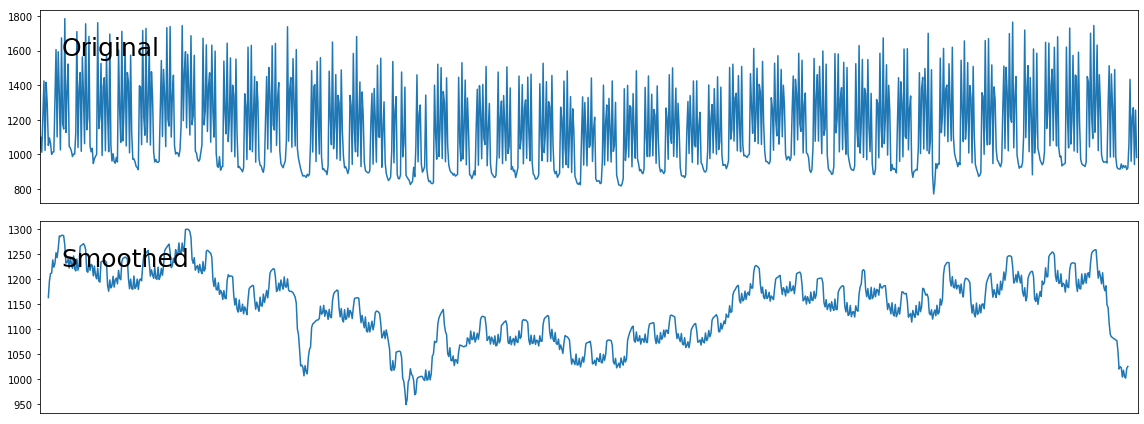

[1023.6857142857143,
 1100.142857142857,
 1012.2,
 1225.7428571428572,
 1424.1714285714286,
 1022.9714285714285,
 1416.7428571428572,
 1288.3142857142857,
 1051.2857142857142,
 1094.7428571428572,
 1062.057142857143,
 999.4,
 1012.8571428571429,
 1014.2285714285714,
 1315.1714285714286,
 1605.7428571428572,
 1100.5714285714287,
 1593.142857142857,
 1344.6285714285714,
 1025.2857142857142,
 1673.2,
 1176.2857142857142,
 1146.0285714285715,
 1784.5714285714287,
 1126.2285714285715,
 1352.3428571428572,
 1522.2285714285715,
 1045.6571428571428,
 1037.2857142857142,
 1019.1142857142858,
 987.1428571428571,
 1001.8,
 1001.0285714285715,
 1123.5428571428572,
 1709.6,
 1039.3714285714286,
 1373.3714285714286,
 1472.6857142857143,
 1017.3428571428572,
 1563.6285714285714,
 1344.7428571428572,
 1061.4571428571428,
 1754.8285714285714,
 1141.3142857142857,
 1209.9714285714285,
 1681.8285714285714,
 1048.6,
 1014.6,
 1034.7714285714285,
 946.5142857142857,
 974.2571428571429,
 988.2571428571429,


In [69]:
# Power Dataset
#power_data = load_csv('Power.csv', input_column=0)
power_data = load_csv('Power1.csv')
#window_size, slide_size = smooth_ASAP(raw_data, resolution=1000)
window_size, slide_size = smooth_simple(power_data, resolution=1000)
print("Window Size: ", window_size)
plot(power_data, window_size, slide_size)

35040


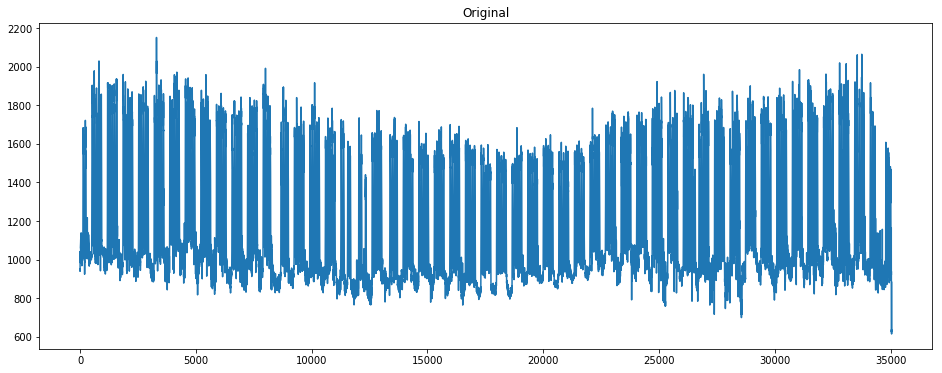

,0
0,950.0
1,939.0
2,943.0
3,971.0
4,1014.0


In [104]:
#Original
#power_data = load_csv('Power.csv', input_column=0)
power_data = load_csv('Power1.csv')
plt.figure(figsize=(16,6))
plt.plot(power_data)
print(len(power_data))
plt.title("Original")
#plt.savefig('original_taxi.pdf')
plt.show()
df = pd.DataFrame(power_data)
df.head()
#power_data
#power_data.head()

In [99]:
# from pandas import read_csv
# df = read_csv('Power.csv')
# df.columns = ['value']
# df.to_csv('Power1.csv')
power_data.head()

AttributeError: 'list' object has no attribute 'head'

In [75]:
#Window Sampling
import calendar

def toTimestamp(d):
  return calendar.timegm(d.timetuple())
def window_sample(data,theta = 5):
    y = "value"
    x = "x"
    if(len(data) <=2):
        return data
    ret = []
    first =  data.iloc[0]
    second = data.iloc[1]
    x1 = toTimestamp(first[x])
    x2 = toTimestamp(second[x])
    y1 = first[y]
    y2 = second[y]
    running_angle = np.rad2deg(np.arctan2(1.0*(y2-y1), 1.0*(x2-x1)/60))
    current_angle = running_angle
    others = data.iloc[2:len(data)]
    ret.append(first)
    prev = second
    for index, current in others.iterrows():
        x1 = toTimestamp(prev[x])
        x2 = toTimestamp(current[x])
        y1 = prev[y]
        y2 = current[y]
        current_angle = np.rad2deg(np.arctan2(1.0*(y2-y1), 1.0*(x2-x1)/60))
        #print("{0} {1} {2} {3} {4}".format(y1,y2,x1,x2,current_angle))
        if abs(current_angle - running_angle) > theta:
            running_angle = current_angle
            ret.append(prev)
            #ret.append(current)
        prev = current
    ret.append(prev)
    return ret
import calendar

import calendar

def toTimestamp(d):
  return calendar.timegm(d.timetuple())
def window_sample_p(data,theta = 5):
    y = "value"
    x = "x"
    if(len(data) <=2):
        return data
    ret = []
    first = data.iloc[0]
    second = data.iloc[1]
    x1 = first[x]
    x2 = second[x]
    y1 = first[y]
    y2 = second[y]
    running_angle = np.rad2deg(np.arctan2(1.0*(y2-y1), 1.0*(x2-x1)/60))
    current_angle = running_angle
    others = data.iloc[2:len(data)]
    ret.append(first)
    prev = second
    for index, current in others.iterrows():
        x1 = prev[x]
        x2 = current[x]
        y1 = prev[y]
        y2 = current[y]
        current_angle = np.rad2deg(np.arctan2(1.0*(y2-y1), 1.0*(x2-x1)/60))
        #print("{0} {1} {2} {3} {4}".format(y1,y2,x1,x2,current_angle))
        if abs(current_angle - running_angle) > theta:
            running_angle = current_angle
            ret.append(prev)
            #ret.append(current)
        prev = current
    ret.append(prev)
    return ret
t = 0
def window_sample_p(data,theta = 5):
    y = "value"
    x = "x"
    if(len(data) <=2):
        return data
    ret = []
    first = data.iloc[0]
    second = data.iloc[1]
    x1 = first[x]
    x2 = second[x]
    y1 = first[y]
    y2 = second[y]
    running_angle = np.rad2deg(np.arctan2(1.0*(y2-y1), 1.0*(x2-x1)/60))
    current_angle = running_angle
    others = data.iloc[2:len(data)]
    ret.append(first)
    prev = second
    for index, current in others.iterrows():
        x1 = prev[x]
        x2 = current[x]
        y1 = prev[y]
        y2 = current[y]
        current_angle = np.rad2deg(np.arctan2(1.0*(y2-y1), 1.0*(x2-x1)/60))
        #print("{0} {1} {2} {3} {4}".format(y1,y2,x1,x2,current_angle))
        if abs(current_angle - running_angle) > theta:
            running_angle = current_angle
            ret.append(prev)
            #ret.append(current)
        prev = current
    ret.append(prev)
    return ret
def fn(x):
    global t
    t = t + 1
    return t

In [93]:
#Window Sample
#temp_data = pd.read_csv('Temp.csv')
#taxi_data["x"] = taxi_data["timestamp"].apply(lambda x: pd.to_datetime(x))
#print(type(taxi_data['timestamp'][0]))
#power_data.head()
#power_data["value"] = [power_data]
#power_data["x"] = temp_data["value"].apply(lambda x : fn(x))
power_data["value"]
power_data["x"] = power_data["occur"].apply(lambda x : fn(x))
sample = window_sample(power_data,100)

# dframe = pd.DataFrame(power_data)
x = np.array(dframe["occur"])
# #print(x)
y = np.array(dframe["value"])

print(len(sample))
plt.figure(figsize=(16,6))
plt.plot(x,y)


#plt.axis('off')
plt.title("WinSamp - Not Working")
#plt.savefig('window_taxi.pdf')
plt.show()

TypeError: list indices must be integers or slices, not str

11680


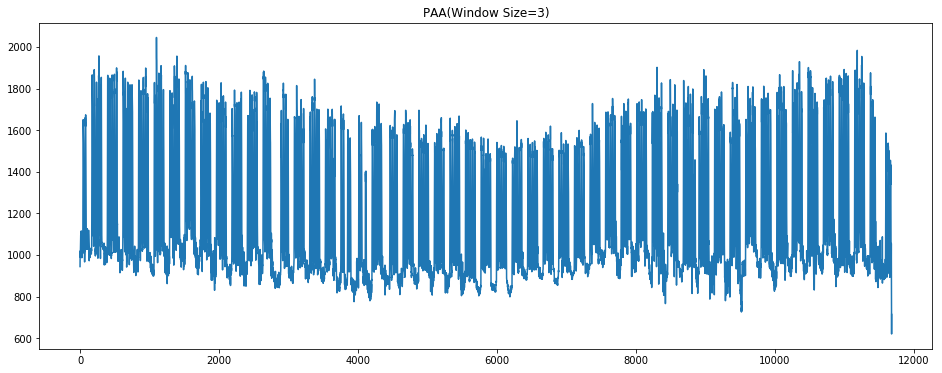

In [79]:
#PAA
window_size = 3
paa = PAA(window_size=window_size)
X_paa = paa.transform([power_data])
print(len(X_paa[0]))
plt.figure(figsize=(16,6))
plt.title("PAA(Window Size=3)")
plt.plot(X_paa[0])
plt.show()

8760


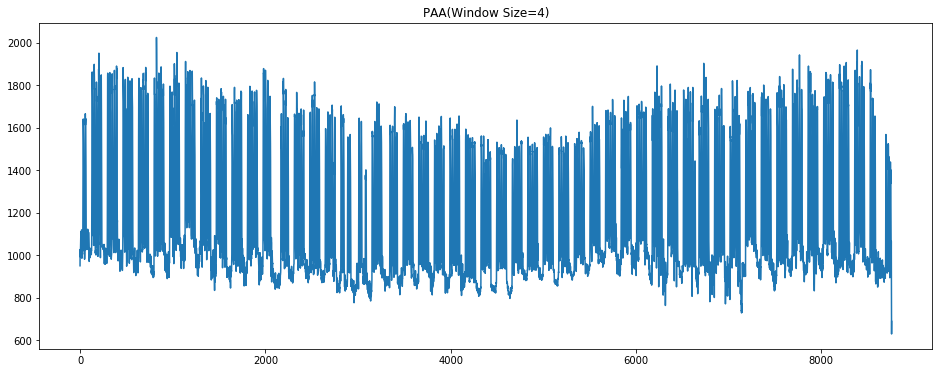

In [39]:
#PAA
window_size = 4
paa = PAA(window_size=window_size)
X_paa = paa.transform([power_data])
print(len(X_paa[0]))
plt.figure(figsize=(16,6))
plt.title("PAA(Window Size=4)")
plt.plot(X_paa[0])
plt.show()

In [43]:
#M4

w = 200
print(4 * w)
#power_data.shape
#power_data.head()
def m4(data, w):
    wsize = data.shape[0]//w
    ret = []
    seen = {}
    for g in range(0,w):
        maxv = None
        minv = None
        first = None
        last = None
        indices = [0,0,0,0]
        for i in range(g*wsize, g*wsize + wsize):
            if minv is None:
                minv = data.iloc[i]
                indices[0] = i
            elif data.iloc[i]["value"] < minv["value"]:
                minv = data.iloc[i]
                indices[0] = i
            if maxv is None:
                maxv = data.iloc[i]
                indices[1] = i
            elif data.iloc[i].value > maxv.value:
                maxv = data.iloc[i]
                indices[1] = i
            if i == g*wsize:
                first = data.iloc[i]
                indices[2] = i
            if i == g*wsize + wsize - 1:
                last = data.iloc[i]
                indices[3] = i
        indices.sort()
        for j in range(0, len(indices)):
            if indices[j] in seen:
                continue
            seen[j] = True
            ret.append(data.iloc[indices[j]])
    df = pd.DataFrame(ret)
    #df = df.sort_values("timestamp")
    return df
ret = m4(power_data,w)

800


AttributeError: 'list' object has no attribute 'shape'

799


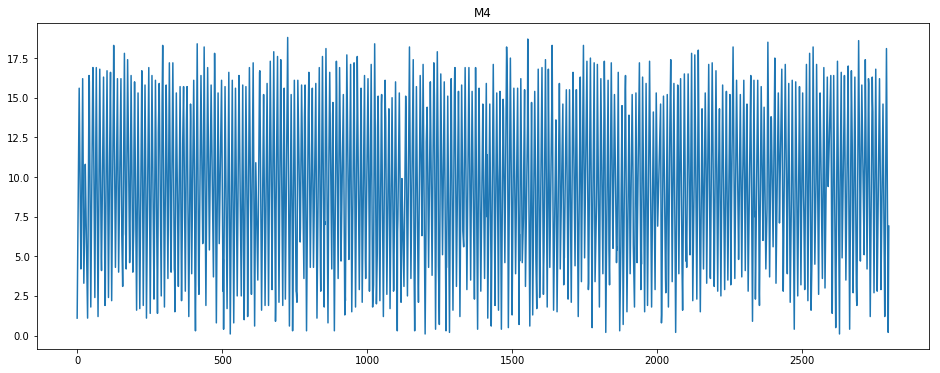

In [41]:
#M4

plt.figure(figsize=(16,6))
plt.plot(ret["value"])
print(len(ret["value"]))
fig = plt.gcf()
plt.title("M4")
#plt.savefig('M4_taxi.pdf')
plt.show()

In [45]:
#Stratified Sampling test
from datetime import datetime, date, time
data = power_data
#print(data.shape)
#print(data.head())
col = "value"
great = datetime(2017,1,5,0,0)

#Stratified temp Data
from sklearn.model_selection import StratifiedShuffleSplit
#start = time()
sss = StratifiedShuffleSplit(n_splits=1, test_size=1 - 0.3, random_state=0)

T = [0]*data.shape[0]
traini= sss.split(data,T)
D = pd.DataFrame()
for t,i in traini:
    print(type(data.iloc[t]))
    D = data.iloc[t]
#print(D)
print(D.shape)
D = D.sort_values(["Month"])
end = time()
#print("--- %s seconds ---" % ((end)-(start))
print(len(D))
x = np.array(D["Month"])
y = np.array(D[col])
plt.figure(figsize=(16,6))
plt.plot(y)
#plt.title("Stratified sampling")
plt.show()

AttributeError: 'list' object has no attribute 'shape'

In [46]:
#Random Sampling Temp Data
import time
#start = time.time()
df = power_data.sample(frac=0.4, replace=True)
#print(temp_data.head())
df = df.sort_values(["Month"])
#end = time.time()
#print("--- %s seconds ---" % (end - start))
print(len(df))
#x = np.array(df["Month"])
y = np.array(df["value"])
#print(df.shape)
plt.figure(figsize=(16,6))
plt.plot(y)
#plt.title("Random sampling")
plt.show()

AttributeError: 'list' object has no attribute 'sample'